# Monte Carlo for Vector Functions of Integrals

Demo Accompanying [Aleksei Sorokin's PyData Chicago 2023 Talk](https://www.meetup.com/pydatachi/events/292071593/)

---

## Monte Carlo Problem

$$\text{True Mean} = \mu = \mathbb{E}[g(T)] = \mathbb{E}[f(X)] = \int_{[0,1]^d} f(x) \mathrm{d} x \approx \frac{1}{n} \sum_{i=0}^{n-1} f(X_i) = \hat{\mu} = \text{Sample Mean}$$

- $T$, original measure on $\mathcal{T}$
- $g: \mathcal{T} \to \mathbb{R}$, original integrand
- $X \sim \mathcal{U}[0,1]^d$, transformed measure
- $f: [0,1]^d \to \mathbb{R}$, transformed integrand

## Python Setup

In [50]:
import qmcpy as qp
import numpy as np
import scipy.stats
import time
from matplotlib import pyplot
pyplot.style.use('../qmcpy.mplstyle')
colors = pyplot.rcParams['axes.prop_cycle'].by_key()['color']
%matplotlib inline

## Discrete Distribution

Generate sampling locations $X_0,\dots,X_{n-1} \sim \mathcal{U}[0,1]^d$

### Independent Identically Distributed (IID) Points for Crude Monte Carlo (CMC)

In [2]:
iid = qp.IIDStdUniform(dimension=3)
iid.gen_samples(n=4)

array([[0.73499967, 0.95795427, 0.34359006],
       [0.38696683, 0.2983072 , 0.10576276],
       [0.60362666, 0.43361841, 0.79725508],
       [0.46838338, 0.07220299, 0.58286275]])

In [3]:
iid.gen_samples(4)

array([[0.47757503, 0.91110836, 0.1459832 ],
       [0.34145097, 0.36972112, 0.1742317 ],
       [0.80031699, 0.0679172 , 0.48704712],
       [0.91338003, 0.53266511, 0.11745996]])

In [32]:
iid

IIDStdUniform (DiscreteDistribution Object)
    d               3
    entropy         333419396675615214994352100864211190664
    spawn_key       ()

### Low Discrepancy (LD) Points for Quasi-Monte Carlo (QMC)

In [4]:
ld_lattice = qp.Lattice(3)
ld_lattice.gen_samples(4)

array([[0.56269964, 0.49461684, 0.06305982],
       [0.06269964, 0.99461684, 0.56305982],
       [0.81269964, 0.24461684, 0.81305982],
       [0.31269964, 0.74461684, 0.31305982]])

In [5]:
ld_lattice.gen_samples(4)

array([[0.56269964, 0.49461684, 0.06305982],
       [0.06269964, 0.99461684, 0.56305982],
       [0.81269964, 0.24461684, 0.81305982],
       [0.31269964, 0.74461684, 0.31305982]])

In [6]:
ld_lattice.gen_samples(n_min=2,n_max=4)

array([[0.81269964, 0.24461684, 0.81305982],
       [0.31269964, 0.74461684, 0.31305982]])

In [31]:
ld_lattice

Lattice (DiscreteDistribution Object)
    d               3
    dvec            [0 1 2]
    randomize       1
    order           natural
    gen_vec         [     1 182667 469891]
    entropy         119354473085892783151429637639696317994
    spawn_key       ()

### Visuals

#### IID vs LD Points

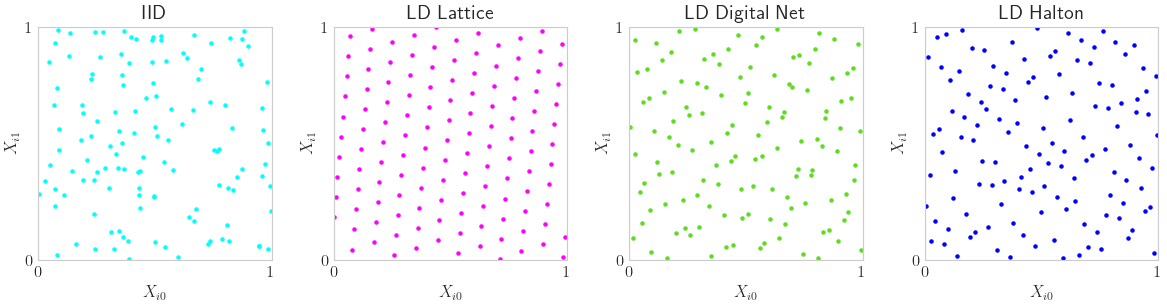

In [7]:
n = 2**7 # Lattice and Digital Net prefer powers of 2 sample sizes
discrete_distribs = {
    'IID': qp.IIDStdUniform(2),
    'LD Lattice': qp.Lattice(2),
    'LD Digital Net': qp.DigitalNetB2(2),
    'LD Halton': qp.Halton(2)}
fig,ax = pyplot.subplots(nrows=1,ncols=len(discrete_distribs),figsize=(3*len(discrete_distribs),3))
ax = np.atleast_1d(ax)
for i,(name,discrete_distrib) in enumerate(discrete_distribs.items()):
    x = discrete_distrib.gen_samples(n)
    ax[i].scatter(x[:,0],x[:,1],s=5,color=colors[i])
    ax[i].set_title(name)
    ax[i].set_aspect(1)
    ax[i].set_xlabel(r'$X_{i0}$'); ax[i].set_ylabel(r'$X_{i1}$')
    ax[i].set_xlim([0,1]); ax[i].set_ylim([0,1])
    ax[i].set_xticks([0,1]); ax[i].set_yticks([0,1])

#### LD Space Filling Extensibility

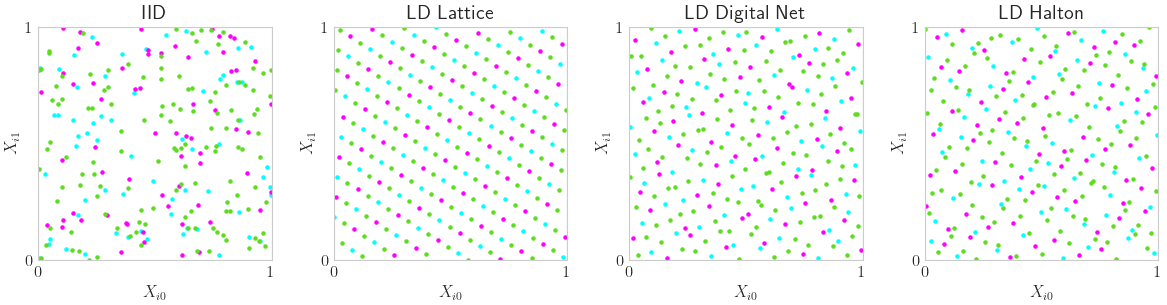

In [8]:
m_min,m_max = 6,8
fig,ax = pyplot.subplots(nrows=1,ncols=len(discrete_distribs),figsize=(3*len(discrete_distribs),3))
ax = np.atleast_1d(ax)
for i,(name,discrete_distrib) in enumerate(discrete_distribs.items()):
    x = discrete_distrib.gen_samples(2**m_max)
    n_min = 0
    for m in range(m_min,m_max+1):
        n_max = 2**m
        ax[i].scatter(x[n_min:n_max,0],x[n_min:n_max,1],s=5,color=colors[m-m_min],label='n_min = %d, n_max = %d'%(n_min,n_max))
        n_min = 2**m
    ax[i].set_title(name)
    ax[i].set_aspect(1)
    ax[i].set_xlabel(r'$X_{i0}$'); ax[i].set_ylabel(r'$X_{i1}$')
    ax[i].set_xlim([0,1]); ax[i].set_ylim([0,1])
    ax[i].set_xticks([0,1]); ax[i].set_yticks([0,1])

#### High Dimensional Pairs Plotting

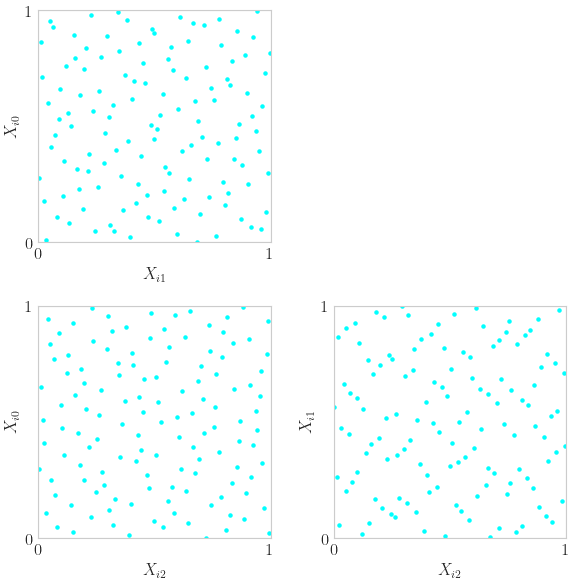

In [9]:
discrete_distrib = qp.DigitalNetB2(3)
x = discrete_distrib(2**7)
d = discrete_distrib.d
assert d>=2
fig,ax = pyplot.subplots(nrows=d,ncols=d,figsize=(3*d,3*d))
for i in range(d):
    fig.delaxes(ax[i,i])
    for j in range(i):
        ax[i,j].scatter(x[:,i],x[:,j],s=5)
        fig.delaxes(ax[j,i])
        ax[i,j].set_aspect(1)
        ax[i,j].set_xlabel(r'$X_{i%d}$'%i); ax[i,j].set_ylabel(r'$X_{i%d}$'%j)
        ax[i,j].set_xlim([0,1]); ax[i,j].set_ylim([0,1])
        ax[i,j].set_xticks([0,1]); ax[i,j].set_yticks([0,1])

## True Measure

Define $T$, facilitate transform from original integrand $g$ to transformed integrand $f$

In [33]:
discrete_distrib = qp.Halton(3)
true_measure = qp.Gaussian(discrete_distrib,mean=[1,2,3],covariance=[4,5,6])
true_measure.gen_samples(4)

array([[ 3.46587883, -0.02474533,  4.2474491 ],
       [ 0.95588386,  2.08934096,  0.89187089],
       [-1.66679354,  4.31053281,  6.90856393],
       [ 1.99851393,  0.78677741,  2.65947797]])

In [34]:
true_measure.gen_samples(n_min=2,n_max=4)

array([[-1.66679354,  4.31053281,  6.90856393],
       [ 1.99851393,  0.78677741,  2.65947797]])

In [35]:
true_measure

Gaussian (TrueMeasure Object)
    mean            [1 2 3]
    covariance      [4 5 6]
    decomp_type     PCA

### Visuals

#### Some True Measure Samplings

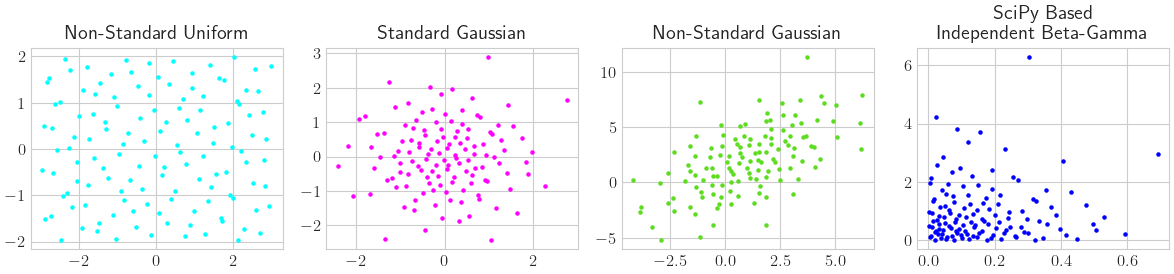

In [39]:
n = 2**7
discrete_distrib = qp.DigitalNetB2(2)
true_measures = {
    'Non-Standard Uniform': qp.Uniform(discrete_distrib,lower_bound=[-3,-2],upper_bound=[3,2]),
    'Standard Gaussian': qp.Gaussian(discrete_distrib),
    'Non-Standard Gaussian': qp.Gaussian(discrete_distrib,mean=[1,2],covariance=[[5,4],[4,9]]),
    'SciPy Based\nIndependent Beta-Gamma': qp.SciPyWrapper(discrete_distrib,[scipy.stats.beta(a=1,b=5),scipy.stats.gamma(a=1)])}
fig,ax = pyplot.subplots(nrows=1,ncols=len(true_measures),figsize=(3*len(true_measures),3))
ax = np.atleast_1d(ax)
for i,(name,true_measure) in enumerate(true_measures.items()):
    t = true_measure.gen_samples(n)
    ax[i].scatter(t[:,0],t[:,1],s=5,color=colors[i])
    ax[i].set_title(name)    

#### Brownian Motion

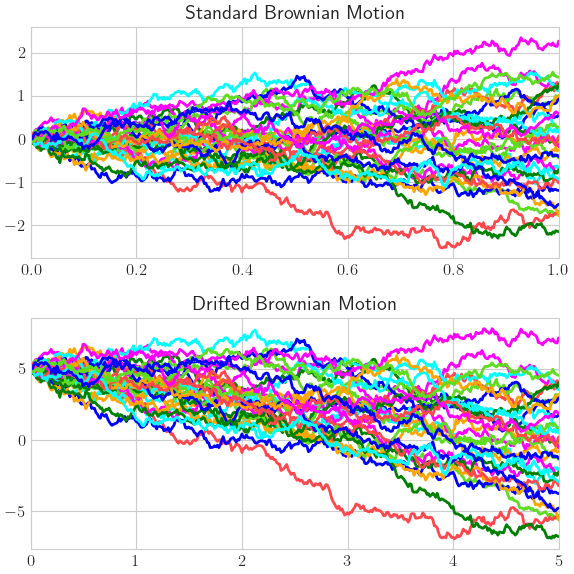

In [41]:
n = 32
discrete_distrib = qp.Lattice(365)
brownian_motions = {
    'Standard Brownian Motion': qp.BrownianMotion(discrete_distrib),
    'Drifted Brownian Motion': qp.BrownianMotion(discrete_distrib,t_final=5,initial_value=5,drift=-1,diffusion=2)}
fig,ax = pyplot.subplots(nrows=len(brownian_motions),ncols=1,figsize=(6,3*len(brownian_motions)))
ax = np.atleast_1d(ax)
for i,(name,brownian_motion) in enumerate(brownian_motions.items()):
    t = brownian_motion.gen_samples(n)
    t_w_init = np.hstack([brownian_motion.initial_value*np.ones((n,1)),t])
    tvec_w_0 = np.hstack([0,brownian_motion.time_vec])
    ax[i].plot(tvec_w_0,t_w_init.T)
    ax[i].set_xlim([tvec_w_0[0],tvec_w_0[-1]])
    ax[i].set_title(name)

## Integrand

Define original integrand $g$, store transformed integrand $f$

### Wrap your Function into QMCPy

Our simple example
$$g(T) = T_0+T_1+\dots+T_{d-1}, \qquad T \sim \mathcal{N}(0,I_d)$$
$$f(X) = g(\Phi^{-1}(X)), \qquad \Phi \text{ standard normal CDF}$$
$$\mathbb{E}[f(X)] = \mathbb{E}[g(T)] = 0$$

In [44]:
def myfun(t): # define g, the ORIGINAL integrand 
    # t an (n,d) shaped np.ndarray of sample from the ORIGINAL (true) measure
    y = t.sum(1)
    return y # an (n,) shaped np.ndarray
true_measure = qp.Gaussian(qp.Halton(5)) # LD Halton discrete distrib for QMC problem
qp_myfun = qp.CustomFun(true_measure,myfun,parallel=False)

### Evalute the Automatically Transformed Integrand

In [45]:
x = qp_myfun.discrete_distrib.gen_samples(4) # samples from the TRANSFORMED measure
y = qp_myfun.f(x) # evaluate the TRANSFORMED integrand at the TRANSFORMED samples
y

array([[ 1.0388889 ],
       [-1.18934972],
       [ 2.8452024 ],
       [-1.84714646]])

### Manual QMC Approximation

Note that when doing importance sampling the below doesn't work. In that case we need to take a specially weighted sum instead instead of the equally weighted sum as done below. 

In [49]:
x = qp_myfun.discrete_distrib.gen_samples(2**16) # samples from the TRANSFORMED measure
y = qp_myfun.f(x) # evaluate the TRANSFORMED integrand at the TRANSFORMED samples
mu_hat = y.mean()
mu_hat

-6.8853050791752e-05

### Predefined Integrands

Many more integrands detailed at https://qmcpy.readthedocs.io/en/master/algorithms.html#integrand-class

Integrands contain their true measure definition, so the user only needs to pass in a sampler. Samplers are often just discrete distributions. 

In [72]:
asian_option = qp.AsianOption(
    sampler = qp.DigitalNetB2(52),
    volatility = 1/2,
    start_price = 30,
    strike_price = 35,
    interest_rate = 0.001,
    t_final = 1,
    call_put = 'call',
    mean_type = 'arithmetic')
x = asian_option.discrete_distrib.gen_samples(2**16)
y = asian_option.f(x)
mu_hat = y.mean()
mu_hat

1.7888875546177119

### Visual Transformation

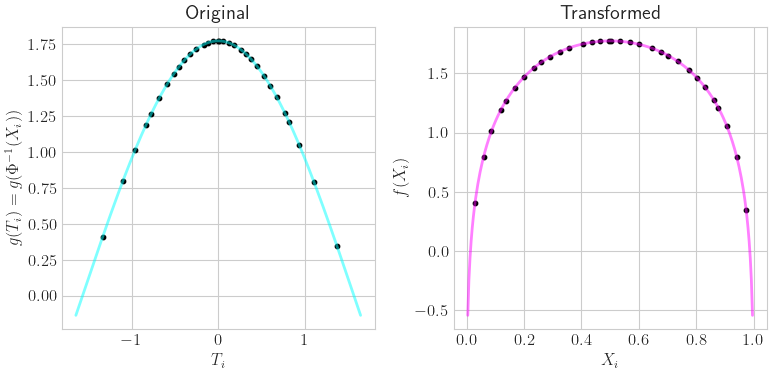

In [107]:
n = 32
keister = qp.Keister(qp.DigitalNetB2(1))
fig,ax = pyplot.subplots(nrows=1,ncols=2,figsize=(8,4))
x = keister.discrete_distrib.gen_samples(n)
t = keister.true_measure.gen_samples(n)
f_of_x = keister.f(x).squeeze()
g_of_t = keister.g(t).squeeze()
assert (f_of_x==g_of_t).all()
x_fine = np.linspace(0,1,257)[1:-1,None]
f_of_xfine = keister.f(x_fine).squeeze()
lb = 1.2*max(abs(t.min()),abs(t.max()))
t_fine = np.linspace(-lb,lb,257)[:,None]
g_of_tfine = keister.g(t_fine).squeeze()
ax[0].set_title(r'Original')
ax[0].set_xlabel(r'$T_i$'); ax[0].set_ylabel(r'$g(T_i) = g(\Phi^{-1}(X_i))$')
ax[0].plot(t_fine.squeeze(),g_of_tfine,color=colors[0],alpha=.5)
ax[0].scatter(t.squeeze(),f_of_x,s=10,color='k')
ax[1].set_title(r'Transformed')
ax[1].set_xlabel(r'$X_i$'); ax[1].set_ylabel(r'$f(X_i)$')
ax[1].scatter(x.squeeze(),f_of_x,s=10,color='k')
ax[1].plot(x_fine.squeeze(),f_of_xfine,color=colors[1],alpha=.5);

## Stopping Criterion

Adaptively increase $n$ until $\lvert \mu - \hat{\mu} \rvert < \varepsilon$ where $\varepsilon$ is a user defined tolerance. 

The stopping criterion should match the discrete distribution e.g. IID CMC stopping criterion for IID points, QMC Lattice stopping criterion for LD Lattice points, QMC digital net stopping criterion for LD digital net points, etc. 

### IID CMC Algorithm

In [126]:
problem_cmc = qp.AsianOption(qp.IIDStdUniform(52))
cmc_stop_crit = qp.CubMCG(problem_cmc,abs_tol=0.025)
approx_cmc,data_cmc = cmc_stop_crit.integrate()
data_cmc

MeanVarData (AccumulateData Object)
    solution        1.788
    error_bound     0.025
    n_total         411133
    n               410109
    levels          1
    time_integrate  2.520
CubMCG (StoppingCriterion Object)
    abs_tol         0.025
    rel_tol         0
    n_init          2^(10)
    n_max           10000000000
    inflate         1.200
    alpha           0.010
AsianOption (Integrand Object)
    volatility      2^(-1)
    call_put        call
    start_price     30
    strike_price    35
    interest_rate   0
    mean_type       arithmetic
    dim_frac        0
BrownianMotion (TrueMeasure Object)
    time_vec        [0.019 0.038 0.058 ... 0.962 0.981 1.   ]
    drift           0
    mean            [0. 0. 0. ... 0. 0. 0.]
    covariance      [[0.019 0.019 0.019 ... 0.019 0.019 0.019]
                    [0.019 0.038 0.038 ... 0.038 0.038 0.038]
                    [0.019 0.038 0.058 ... 0.058 0.058 0.058]
                    ...
                    [0.019 0.038 0.058

### LD QMC Algorithm

In [127]:
problem_qmc = qp.AsianOption(qp.DigitalNetB2(52))
qmc_stop_crit = qp.CubQMCNetG(problem_qmc,abs_tol=0.025)
approx_qmc,data_qmc = qmc_stop_crit.integrate()
data_qmc

LDTransformData (AccumulateData Object)
    solution        1.783
    comb_bound_low  1.759
    comb_bound_high 1.806
    comb_flags      1
    n_total         2^(10)
    n               2^(10)
    time_integrate  0.005
CubQMCNetG (StoppingCriterion Object)
    abs_tol         0.025
    rel_tol         0
    n_init          2^(10)
    n_max           2^(35)
AsianOption (Integrand Object)
    volatility      2^(-1)
    call_put        call
    start_price     30
    strike_price    35
    interest_rate   0
    mean_type       arithmetic
    dim_frac        0
BrownianMotion (TrueMeasure Object)
    time_vec        [0.019 0.038 0.058 ... 0.962 0.981 1.   ]
    drift           0
    mean            [0. 0. 0. ... 0. 0. 0.]
    covariance      [[0.019 0.019 0.019 ... 0.019 0.019 0.019]
                    [0.019 0.038 0.038 ... 0.038 0.038 0.038]
                    [0.019 0.038 0.058 ... 0.058 0.058 0.058]
                    ...
                    [0.019 0.038 0.058 ... 0.962 0.962 0.962]

In [128]:
print('QMC took %.2f%% the time and %.2f%% the samples compared to CMC'%(
      100*data_qmc.time_integrate/data_cmc.time_integrate,100*data_qmc.n_total/data_cmc.n_total))

QMC took 0.20% the time and 0.25% the samples compared to CMC


### Visual CMC vs LD

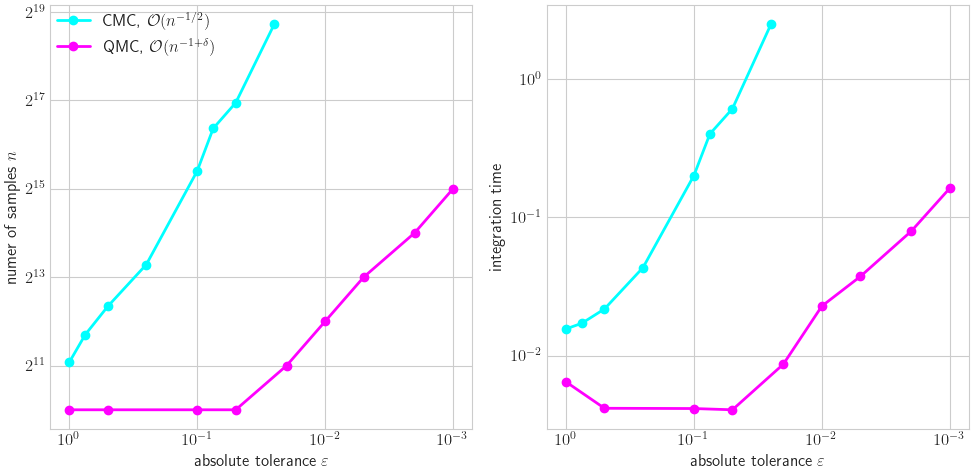

In [150]:
cmc_tols = [1,.75,.5,.25,.1,.075,.05,.025]
qmc_tols = [1,.5,.1,.05,.02,.01,.005,.002,.001]
fig,ax = pyplot.subplots(nrows=1,ncols=2,figsize=(10,5))
n_cmc,time_cmc = np.zeros_like(cmc_tols),np.zeros_like(cmc_tols)
for i,cmc_tol in enumerate(cmc_tols):
    cmc_stop_crit = qp.CubMCG( qp.AsianOption(qp.IIDStdUniform(52)),abs_tol=cmc_tol)
    approx_cmc,data_cmc = cmc_stop_crit.integrate()
    n_cmc[i],time_cmc[i] = data_cmc.n_total,data_cmc.time_integrate
ax[0].plot(cmc_tols,n_cmc,'-o',color=colors[0],label=r'CMC, $\mathcal{O}(n^{-1/2})$')
ax[1].plot(cmc_tols,time_cmc,'-o',color=colors[0])
n_qmc,time_qmc = np.zeros_like(qmc_tols),np.zeros_like(qmc_tols)
for i,qmc_tol in enumerate(qmc_tols):
    qmc_stop_crit = qp.CubQMCNetG(qp.AsianOption(qp.DigitalNetB2(52)),abs_tol=qmc_tol)
    approx_qmc,data_qmc = qmc_stop_crit.integrate()
    n_qmc[i],time_qmc[i] = data_qmc.n_total,data_qmc.time_integrate
ax[0].plot(qmc_tols,n_qmc,'-o',color=colors[1],label=r'QMC, $\mathcal{O}(n^{-1+\delta})$')
ax[1].plot(qmc_tols,time_qmc,'-o',color=colors[1])
ax[0].set_xscale('log',base=10); ax[0].set_yscale('log',base=2)
ax[1].set_xscale('log',base=10); ax[1].set_yscale('log',base=10)
ax[0].invert_xaxis(); ax[1].invert_xaxis()
ax[0].set_xlabel(r'absolute tolerance $\varepsilon$'); ax[1].set_xlabel(r'absolute tolerance $\varepsilon$')
ax[0].set_ylabel(r'numer of samples $n$'); ax[1].set_ylabel('integration time')
ax[0].legend(loc='upper left');

## Vectorized Stopping Criterion